In [6]:
#import all dependencies

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
#Reading data
dnameth = pd.read_csv("G9_liver_dna-meth.csv")
mystery = pd.read_csv("mystery_dna-meth.csv")

#Pre-processing data
dnameth.dropna()
dnameth.iloc[:, 1].unique()
dnameth = dnameth.rename(columns = {'Primary Tumor':'0'})

mystery.dropna()
mystery.iloc[:, 1].unique()
mystery.rename(columns = {'Primary Tumor':'0'})


#Defining dependant variable
y = mystery['Label'].values
y_myst = mystery['Label'].values


#Encoding categorical data
Labelencoder = LabelEncoder()
Y_encoding = Labelencoder.fit_transform(y) # Primary Tumor = 0, Solid Tissue Normal = 1
y_mystencoding = Labelencoder.fit_transform(y_myst)

# Define the independent variables to drop the Label and Unnamed: 0
X = mystery.drop(labels = ['Label','Unnamed: 0'], axis = 1)
X_myst = mystery.drop(labels = ['Label','Unnamed: 0'], axis = 1)
feature_names = np.array(X.columns)



In [8]:
#Normalisation
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)
X_log2 = np.log2(X)
X_log2 = scaler.fit_transform(X_log2)
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_encoding, test_size = 0.3, random_state = 42)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


new_X=[]
new_Y=[]
for subarr in X_train:
    new_X.append(subarr[np.isfinite(subarr)])

for subarr in Y_train:
    new_Y.append(subarr[np.isfinite(subarr)])

scaler.fit(X_myst)
X_mystscale = scaler.transform(X_myst)

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
# Hyperparameters
learning_rate = 0.00005
epochs = 1000

# Variables for controlling the test example
test_example = torch.tensor(X_test, dtype=torch.float32)


# Variables
X = torch.tensor(new_X, dtype=torch.float32)
Y = torch.tensor(new_Y, dtype=torch.float32)
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


num_samples, num_features = X.shape


input_size = num_features
output_size = num_samples

class Detector(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Detector, self).__init__()    
        self.lin = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.lin(x)

model = Detector(input_size, output_size)    


loss = nn.MSELoss()
loss_over_time = []
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
# Training loop
for epoch in range(epochs):

    total_loss = 0
    
    for i in range(num_samples):

        # Forward pass
        y_pred = model(X[i])
    
        # Calculate Loss
        l = loss(y_pred, Y[i])
        
        # Calculate gradients
        l.backward()

        total_loss += float(l)
    
    print(total_loss)
    loss_over_time.append(total_loss)
    # Update weights
    optimiser.step()
    optimiser.zero_grad()

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([266])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


468.29273185133934
162.43252910673618
141.10279670357704
133.1830763965845
126.65444265305996
120.87874518334866
115.73331578075886
111.13201706111431
107.00213360786438
103.28155535459518
99.91714642941952
96.86338612437248
94.0812364667654
91.5371635183692
89.20232090353966
87.05186328291893
85.06434947997332
83.22125031799078
81.50651540607214
79.90622840076685
78.40828638523817
77.00215033441782
75.67861910909414
74.4296463727951
73.24817215651274
72.12799382209778
71.06364764273167
70.05030359327793
69.08368583023548
68.15999779850245
67.27586101740599
66.42825834453106
65.614487439394
64.83212707936764
64.07899470627308
63.353124007582664
62.65273439139128
61.97620880976319
61.322081577032804
60.689013693481684
60.07577911391854
59.48125958070159
58.90442345291376
58.344325587153435
57.800090696662664
57.270909413695335
56.75603598728776
56.25477557256818
55.76648209616542
55.29055403545499
54.826431550085545
54.37358946353197
53.93153811991215
53.499816592782736
53.0779929272830

True positives:  51
True negatives:  58
False positives:  4
False negatives:  0
Accuracy:  0.9646017699115044


Text(0, 0.5, 'Total Mean Squared Error')

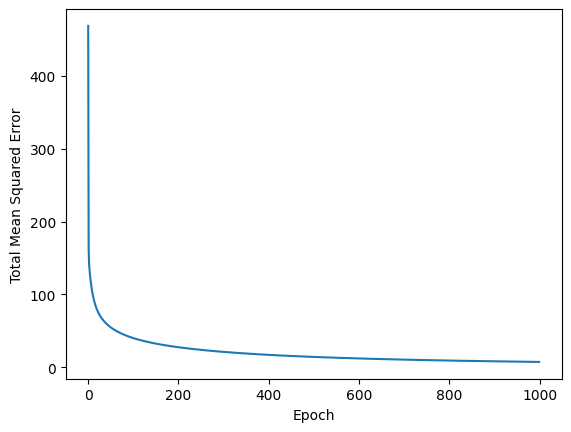

In [12]:
new_Xtest = []
new_Ytest = []
for subarr in X_test:
    new_Xtest.append(subarr[np.isfinite(subarr)])

for subarr in Y_test:
    new_Ytest.append(subarr[np.isfinite(subarr)])

test_example = torch.tensor(new_Xtest, dtype=torch.float32)

with torch.inference_mode():
    prediction = model(test_example)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
mean = 0;
for row in prediction:
    mean = int(torch.round(torch.mean(row)))
    rounded_prediction.append(mean)


tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in new_Ytest:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

print("True positives: ", tp)
print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))

plt.plot(loss_over_time)
plt.xlabel("Epoch")
plt.ylabel("Total Mean Squared Error")

In [ ]:
new_X = []
for subarr in X_mystscale:
    new_X.append(subarr[np.isfinite(subarr)])




Xmyst = torch.tensor(new_X, dtype=torch.float32)
Ymyst = torch.tensor(y_mystencoding, dtype=torch.float32)


with torch.inference_mode():
    prediction = model(Xmyst)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
mean = 0;
for row in prediction:
    mean = int(torch.round(torch.mean(row)))
    rounded_prediction.append(mean)


tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in Ymyst:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

    print("True positives: ", tp)
    print("True negatives: ", tn)
    print("False positives: ", fp)
    print("False negatives: ", fn)
    print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))


True positives:  0
True negatives:  1
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  2
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  3
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  4
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  5
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  6
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  7
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  8
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  9
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  10
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  11
False positives:  0
False nega

C:\Users\oolba\AppData\Local\Temp\ipykernel_22736\113622495.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  Xmyst = torch.tensor(new_X, dtype=torch.float32)


IndexError: list index out of range